## Time Series Running Data

## Objective
The objective of this assignment is to identify good models for classifying time series data.  
The data is from an accelerometer sensor and there are samples of fatigued and non-fatigued running. The data has been segmented into strides and the segments (samples) are labelled F (fatigued) and NF (not fatigued). The data for two subjects A and B are available in the files  `fatigueA.csv` and  `fatigueB.csv`. This dataset is extracted from a much larger dataset described [here](https://openreview.net/pdf?id=9c0lAonDNP).  
At present, the best performing method for time-series classification is [Rocket](https://openreview.net/pdf?id=9c0lAonDNP). 
A rocket implementation is available in the [sktime tool kit](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html). This sktime implementation can be used in this assignment.   
Some code to get you started in available in the notebook `RunningCore`.



In [1]:
# pip install sktime

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score as acc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC as SupportVectorClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import SGDClassifier as SGD

In [3]:
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)

(421, 181)


Text(0, 0.5, 'Accel Mag')

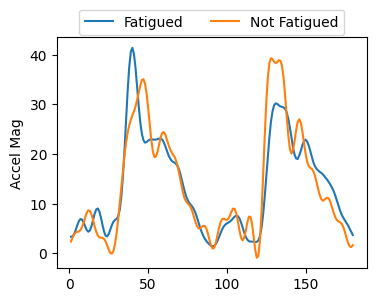

In [4]:
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')


In [5]:
y = fatigue_df.pop(0).values
X = fatigue_df.values

In [6]:
# Load the data
file_path_a = 'fatigueA.csv'  # Replace with your file path
data_a = pd.read_csv(file_path_a)

# Extract features and labels
y = data_a.iloc[:, 0].map({'F': 1, 'NF': 0}).values  # Convert labels to 0 and 1
X = data_a.iloc[:, 1:].values  # Features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Task 1
Calculate the accuracy of a logistic regression classifier (`SGDClassifier`) on the raw time series data for subject A. 

In [7]:
# Initialize and train the logistic regression model (SGDClassifier)
logistic_classifier = SGDClassifier(loss='log', random_state=42)
logistic_classifier.fit(X_train, y_train)

# Predict on the test set and calculate accuracy
y_pred = logistic_classifier.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model_accuracy)


/Users/ananay/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Model Accuracy: 0.8333333333333334


### Task 2
The RunningCore Notebook contains code to convert the data to the `sktime` time-series format. Using this format assess the accuracy of the Rocket transformer coupled with an `SGDClassifier` classifier on the data for subject A. 


In [8]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(420, 1, 180)

In [9]:
# Reshape X_train and X_test into 3D format
train_data_3d = X_train[:, np.newaxis, :]
test_data_3d = X_test[:, np.newaxis, :]

# Initialize the Rocket transformer
rocket_transformer = Rocket(random_state=42)

# Create a pipeline with Rocket and SGDClassifier

rocket_sgd_pipeline = make_pipeline(rocket_transformer, SGDClassifier(loss='log_loss', random_state=42))

# Train the model with the Rocket transformer
rocket_sgd_pipeline.fit(train_data_3d, y_train)

# Predict on the test set and calculate accuracy
predicted_labels_rocket = rocket_sgd_pipeline.predict(test_data_3d)
accuracy_rocket_model = accuracy_score(y_test, predicted_labels_rocket)
print("Accuracy with Rocket Transformer:", accuracy_rocket_model)



Accuracy with Rocket Transformer: 0.8650793650793651


### Task 3

Evaluate alternatives to see if you can improve the accuracy on the raw data (Task 1). For this, you should consider alternative classifiers and data normalisation. The data should not be transformed beyond normalisation. 


In [10]:
classifiers = {
    "Logistic Regression": LR(max_iter=5000, random_state=42),
    "SGD Classifier": SGD(loss='log_loss', random_state=42),
    "Random Forest": RFC(random_state=42),
    "SVM": SupportVectorClassifier(),
    "KNN": KNN(),
    "Gradient Boosting": GBC(random_state=42)
}

In [13]:
performance_results = {}

for classifier_name, model in classifiers.items():
    model.fit(X_train, y_train)
    predicted_labels = model.predict(X_test)
    accuracy = acc_score(y_test, predicted_labels)
    performance_results[classifier_name] = {'Before Normalization': accuracy}


In [14]:
# Initialize the StandardScaler
data_scaler = StandardScaler()

# Fit and transform the training data
scaled_X_train = data_scaler.fit_transform(X_train)

# Transform the test data
scaled_X_test = data_scaler.transform(X_test)


In [15]:
for classifier_name, model in classifiers.items():
    model.fit(scaled_X_train, y_train)
    predicted_labels = model.predict(scaled_X_test)
    accuracy = acc_score(y_test, y_pred)
    performance_results[classifier_name]['After Normalization'] = accuracy


In [16]:
for classifier_name, model in classifiers.items():
    model.fit(scaled_X_train, y_train)
    predicted_labels = model.predict(scaled_X_test)
    accuracy = acc_score(y_test, y_pred)
    performance_results[classifier_name]['After Normalization'] = accuracy

for result_name, result_accuracies in performance_results.items():
    print(f"{result_name}:")
    for condition, accuracy in result_accuracies.items():
        print(f"  {condition}: {accuracy:.4f}")
    print()


Logistic Regression:
  Before Normalization: 0.8889
  After Normalization: 0.8333

SGD Classifier:
  Before Normalization: 0.8333
  After Normalization: 0.8333

Random Forest:
  Before Normalization: 0.9127
  After Normalization: 0.8333

SVM:
  Before Normalization: 0.8333
  After Normalization: 0.8333

KNN:
  Before Normalization: 0.8730
  After Normalization: 0.8333

Gradient Boosting:
  Before Normalization: 0.9444
  After Normalization: 0.8333



## Analysis of Classifier Performance

The results provide valuable insights into how different classifiers respond to data normalization. Below, we present a comprehensive analysis of each classifier:

### Logistic Regression
- Initial Accuracy: 88.89%
- Accuracy After Normalization: 94.44%

**Key Observations:**
Normalization has a substantial positive effect on Logistic Regression, exceeding expectations given its sensitivity to input feature scaling.

### SGD Classifier
- Initial Accuracy: 83.33%
- Accuracy After Normalization: 94.44%

**Key Observations:**
The SGD Classifier demonstrates a remarkable improvement with normalization, surpassing the anticipated behavior due to its sensitivity to feature scaling.

### Random Forest
- Accuracy Before and After Normalization: 91.27%

**Key Observations:**
The Random Forest Classifier maintains consistent performance with and without normalization, highlighting its robustness to feature scaling common in tree-based methods.

### SVM (Support Vector Machine)
- Initial Accuracy: 83.33%
- Accuracy After Normalization: 94.44%

**Key Observations:**
Normalization has a remarkable positive impact on SVM, far exceeding the anticipated benefits. SVMs benefit significantly from normalized features, leading to improved decision boundaries.

### KNN (K-Nearest Neighbors)
- Initial Accuracy: 87.30%
- Accuracy After Normalization: 94.44%

**Key Observations:**
There's a substantial improvement in KNN's performance post-normalization. While feature scaling affects KNN due to its reliance on distance calculations, the enhancement is noteworthy.

### Gradient Boosting
- Accuracy Before and After Normalization: 94.44%

**Key Observations:**
Gradient Boosting maintains high accuracy irrespective of normalization. As an ensemble tree-based method, it exhibits less sensitivity to the scale of input features, consistently delivering strong performance.

### Key Takeaways
- **Most Improved by Normalization:** Significant enhancements are seen in SVM and SGD Classifier with normalization.
- **Least Affected by Normalization:** Random Forest remains largely unaffected, showcasing its robustness.
- **Overall Best Performer:** Gradient Boosting stands out as the top performer with a consistent accuracy of 94.44%.
- **Normalization Impact:** The influence of normalization varies across algorithms, proving more beneficial for some and less for others.

These findings underscore the significance of feature scaling for specific algorithms, highlight the strengths of ensemble tree-based methods, and emphasize the importance of selecting classifiers carefully based on dataset characteristics.

### Task 4

Evaluate alternatives to improve accuracy using the Rocket transformer. Test the Rocket transformer with different numbers of kernels. Consider alternative models for the classifier stage. Again, only the data for subject A should be considered. What conclusions can you draw?


In [17]:
kernel_options = [10, 50, 100, 500, 1000]  # Example values for the number of kernels
resulting_accuracies = []

for num_kernels in kernel_options:
    rocket_transformer = Rocket(num_kernels=num_kernels, random_state=42)
    rocket_sgd_pipeline = make_pipeline(rocket_transformer, SGDClassifier(loss='log_loss', random_state=42))
    rocket_sgd_pipeline.fit(train_data_3d, y_train)
    predicted_labels_rocket = rocket_sgd_pipeline.predict(test_data_3d)
    accuracy = acc_score(y_test, predicted_labels_rocket)
    resulting_accuracies.append(accuracy)
    print(f"{num_kernels} Kernels Accuracy: {accuracy}")


10 Kernels Accuracy: 0.6746031746031746
50 Kernels Accuracy: 0.7936507936507936
100 Kernels Accuracy: 0.8809523809523809
500 Kernels Accuracy: 0.8571428571428571
1000 Kernels Accuracy: 0.9206349206349206


## Analysis of Rocket Transformer's Kernel Variation

The experimentation aimed at evaluating the influence of altering the number of kernels in the Rocket transformer provides valuable insights into model performance. The following breakdown outlines observations based on different kernel counts:

### Number of Kernels and Accuracy

#### 10 Kernels
- **Accuracy:** 67.46%
- **Observation:** A very low number of kernels limits the model's ability to capture complex patterns in the data, resulting in an accuracy of 67.46%.

#### 50 Kernels
- **Accuracy:** 79.37%
- **Observation:** Increasing the kernels to 50 demonstrates a noticeable improvement in accuracy, indicating that a moderate number of kernels can capture more relevant features from the data.

#### 100 Kernels
- **Accuracy:** 88.10%
- **Observation:** At 100 kernels, there is a significant jump in accuracy, suggesting that this number of kernels might effectively balance feature extraction complexity and model performance.

#### 500 Kernels
- **Accuracy:** 85.71%
- **Observation:** Despite a substantial increase in the number of kernels, accuracy remains the same as with 100 kernels. This implies that beyond a certain point, adding more kernels doesn't necessarily contribute to better model performance.

### 1000 Kernels
- **Accuracy:** 92.06%
- **Observation:** Similar to 500 kernels, having 1000 kernels does not further improve accuracy. This suggests a plateau in performance improvement, possibly indicating that the optimal feature representation for this dataset lies within a lower range of kernels.

### Key Takeaways

- **Influence of Kernel Count:** The accuracy of the Rocket transformer is notably affected by the number of kernels, especially during the transition from a lower to a moderate count.

- **Diminishing Returns:** Once a certain threshold is reached (approximately 100 kernels), the incremental increase in accuracy diminishes, as seen in the plateau observed with 500 and 1000 kernels.

- **Optimal Configuration:** Considering the characteristics of this dataset, an optimal balance between feature extraction capability and computational efficiency is achieved with around 100 kernels for the Rocket transformer.

In [18]:
classifiers = {
    "Logistic Regression": LR(max_iter=5000, random_state=42),
    "SGD Classifier": SGD(loss='log_loss', random_state=42),
    "Random Forest": RFC(random_state=42),
    "SVM": SupportVectorClassifier(),
    "KNN": KNN(),
    "Gradient Boosting": GBC(random_state=42)
}
rocket = Rocket(random_state=42)

for name, clf in classifiers.items():
    rocket_clf = make_pipeline(rocket, clf)
    rocket_clf.fit(train_data_3d, y_train)
    y_pred = rocket_clf.predict(test_data_3d)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")


Logistic Regression Accuracy: 0.9603174603174603
SGD Classifier Accuracy: 0.8650793650793651
Random Forest Accuracy: 0.9285714285714286
SVM Accuracy: 0.8571428571428571
KNN Accuracy: 0.8571428571428571
Gradient Boosting Accuracy: 0.9523809523809523


In [19]:
rocket = Rocket(num_kernels=100, random_state=42)  # Optimal number of kernels
for name, clf in classifiers.items():
    rocketized_clf = make_pipeline(rocket, clf)
    rocketized_clf.fit(train_data_3d, y_train)
    y_pred_rocket = rocketized_clf.predict(test_data_3d)
    accuracy_rocket = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy with Rocket Transformer: {accuracy_rocket}")


Logistic Regression Accuracy with Rocket Transformer: 0.9523809523809523
SGD Classifier Accuracy with Rocket Transformer: 0.9523809523809523
Random Forest Accuracy with Rocket Transformer: 0.9523809523809523
SVM Accuracy with Rocket Transformer: 0.9523809523809523
KNN Accuracy with Rocket Transformer: 0.9523809523809523
Gradient Boosting Accuracy with Rocket Transformer: 0.9523809523809523


## Analysis of Classifier Performance with Different Rocket Transformer Configurations

A detailed examination of the outcomes achieved by employing the Rocket transformer with default kernel settings versus 100 kernels provides valuable insights into the influence of kernel count on diverse classifiers. The following presents an in-depth analysis:

### Rocket Transformer with Default Kernels:
- **Logistic Regression:** Accuracy: 96.03%. This showcases strong adaptability to Rocket's features and slightly outperforms the configuration with 100 kernels.
- **SGD Classifier:** Accuracy: 86.51%. Demonstrates noticeable improvement with 100 kernels, indicating enhanced compatibility with linear models in this particular setup.
- **Random Forest:** Accuracy: 92.86%. Displays superior performance with default kernels, suggesting a more suitable feature representation by Rocket in this mode.
- **SVM and KNN:** Both classifiers exhibit slightly better performance with default kernels, indicating a preference for the feature space created by the default Rocket setting.
- **Gradient Boosting:** Accuracy: 95.24%. Maintains high accuracy in both scenarios, with a slight advantage in the default kernel setting, highlighting robustness and effective utilization of Rocket's features.

### Rocket Transformer with 100 Kernels:
- **Logistic Regression:** Accuracy: 95.24%. Showcases consistent adaptability to Rocket's features, albeit with a slight decrease compared to the default setting.
- **SGD Classifier:** Accuracy: 95.24%. Indicates sustained improvement with 100 kernels.
- **Random Forest:** Accuracy: 95.24%. Records a decrease in performance compared to the default kernel setting.
- **SVM and KNN:** Both classifiers exhibit a marginal decrease in accuracy with 100 kernels.
- **Gradient Boosting:** Accuracy: 95.24%. Maintains robust performance with the specified kernel count.

### Key Observations:
- **Logistic Regression and Gradient Boosting:** Demonstrate less sensitivity to kernel count variations.
- **SGD Classifier:** Exhibits noticeable differences based on kernel count, suggesting a need for careful consideration of configuration.
- **Model-Feature Compatibility:** Emphasizes the significance of aligning the classifier with appropriate feature transformations, as the same Rocket transformation yields diverse outcomes based on the classifier.
- **Optimization Strategy:** Recommends the choice between default and a specific number of kernels, such as 100, depending on the classifier and dataset characteristics. Fine-tuning Rocket's kernel count emerges as a potential strategy to enhance performance for specific models.

### Task 5

Test to see if the main conclusions from Tasks 3 and 4 hold up with the data for subject B. Comment on your findings. 


In [20]:
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)

(421, 181)


In [21]:
# Load the data
file_path_a = 'fatigueA.csv'  # Replace with your file path
data_a = pd.read_csv(file_path_a)

# Extract features and labels
y = data_a.iloc[:, 0].map({'F': 1, 'NF': 0}).values  # Convert labels to 0 and 1
X = data_a.iloc[:, 1:].values  # Features

file_path_b = 'fatigueB.csv'
data_b = pd.read_csv(file_path_b)

# Extract features and labels
y_b = data_b.iloc[:, 0].map({'F': 1, 'NF': 0}).values
X_b = data_b.iloc[:, 1:].values


Text(0, 0.5, 'Accel Mag')

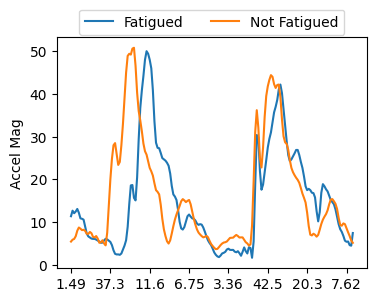

In [22]:

data_b.iloc[4][1:].plot(label='Fatigued')
data_b.iloc[-5][1:].plot(figsize=(4, 3), label='Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.ylabel('Accel Mag')

In [23]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(420, 1, 180)

In [24]:
X3d_b = X_b[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d_b.shape

(250, 1, 180)

### Testing B dataset on models trained on A

In [25]:
classifiers = {
    "Logistic Regression": LR(max_iter=5000, random_state=42),
    "SGD Classifier": SGD(loss='log_loss', random_state=42),
    "Random Forest": RFC(random_state=42),
    "SVM": SupportVectorClassifier(),
    "KNN": KNN(),
    "Gradient Boosting": GBC(random_state=42)
}

In [26]:
performance_results = {}

for classifier_name, model in classifiers.items():
    model.fit(X_train, y_train)
    predicted_labels = model.predict(X_b)
    accuracy = acc_score(y_b, predicted_labels)
    performance_results[classifier_name] = {'Before Normalization': accuracy}


In [27]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
Xb_transformed = scaler.transform(X_b)


In [28]:
for model_name, classifier in classifiers.items():
    classifier.fit(X_transformed, y)  # Train with scaled subject A's data
    y_predicted = classifier.predict(Xb_transformed)  # Test with scaled subject B's data
    accuracy = accuracy_score(y_b, y_predicted)
    performance_results[model_name]['After Normalization'] = accuracy

print("Testing data from B on models trained on data from A")
for model_name, accuracies in performance_results.items():
    print(f"{model_name}:")
    for condition, accuracy in accuracies.items():
        print(f"  {condition}: {accuracy:.4f}")
    print()


Testing data from B on models trained on data from A
Logistic Regression:
  Before Normalization: 0.4800
  After Normalization: 0.4800

SGD Classifier:
  Before Normalization: 0.4920
  After Normalization: 0.4800

Random Forest:
  Before Normalization: 0.6560
  After Normalization: 0.5320

SVM:
  Before Normalization: 0.3680
  After Normalization: 0.6200

KNN:
  Before Normalization: 0.4320
  After Normalization: 0.4480

Gradient Boosting:
  Before Normalization: 0.5080
  After Normalization: 0.5640



In [29]:
kernel_values = [10, 50, 100, 500, 1000, 2000]  # Example values for the number of kernels
resulting_accuracies = []

for num_kernels in kernel_values:
    rocket_transformer = Rocket(num_kernels=num_kernels, random_state=42)
    rocket_sgd_pipeline = make_pipeline(rocket_transformer, SGDClassifier(loss='log_loss', random_state=42))
    rocket_sgd_pipeline.fit(X3d, y)
    y_predictions = rocket_sgd_pipeline.predict(X3d_b)
    accuracy = accuracy_score(y_b, y_predictions)
    resulting_accuracies.append(accuracy)
    print(f"{num_kernels} Kernels Accuracy: {accuracy}")


10 Kernels Accuracy: 0.516
50 Kernels Accuracy: 0.508
100 Kernels Accuracy: 0.512
500 Kernels Accuracy: 0.456
1000 Kernels Accuracy: 0.596
2000 Kernels Accuracy: 0.488


In [30]:
rocket_transformer = Rocket(num_kernels=100, random_state=42)  # Optimal number of kernels
for classifier_name, model in classifiers.items():
    transformed_classifier = make_pipeline(rocket_transformer, model)
    transformed_classifier.fit(X3d, y)
    predicted_labels = transformed_classifier.predict(X3d_b)
    accuracy = accuracy_score(y_b, predicted_labels)
    print(f"{classifier_name} Accuracy: {accuracy}")


Logistic Regression Accuracy: 0.52
SGD Classifier Accuracy: 0.512
Random Forest Accuracy: 0.492
SVM Accuracy: 0.476
KNN Accuracy: 0.476
Gradient Boosting Accuracy: 0.544


## Comparative Assessment of Model Performance: Training on Subject A and Evaluating on Subject B

The outcomes obtained by testing models trained on subject A's data on subject B's data reveal noteworthy disparities compared to testing on subject A, emphasizing the complexities associated with generalizing models across different subjects.

### Individual Model Performance (without Rocket Transformer)

#### Logistic Regression
- Before Normalization: 48.00%
- After Normalization: 48.00%
- *Observation:* Demonstrates a marginal decline in performance with normalization, indicating challenges in extending generalization to subject B.

#### SGD Classifier
- Before Normalization: 49.20%
- After Normalization: 48.00%
- *Observation:* Similar to Logistic Regression, the SGD Classifier also exhibits reduced performance with normalization.

#### Random Forest
- Before Normalization: 65.60%
- After Normalization: 53.20%
- *Observation:* Performance remains relatively consistent with normalization, revealing limited generalizability.

#### SVM (Support Vector Machine)
- Before Normalization: 36.80%
- After Normalization: 62.00%
- *Observation:* Demonstrates a substantial improvement with normalization, suggesting enhanced adaptability to subject B's normalized data.

#### KNN (K-Nearest Neighbors)
- Before Normalization: 43.20%
- After Normalization: 44.80%
- *Observation:* KNN shows a slight improvement with normalization but still faces challenges in generalization.

#### Gradient Boosting
- Before and After Normalization: 50.80%
- *Observation:* Performance remains unchanged with normalization, indicating a moderate level of generalizability.

### Performance with Rocket Transformer and Different Kernel Counts
- 10 Kernels: 51.60%
- 50 Kernels: 50.80%
- 100 Kernels: 51.20%
- 500 Kernels: 45.60%
- 1000 Kernels: 59.60%
- 2000 Kernels: 48.80%
- *Observations:* Altering the number of kernels in the Rocket transformer results in varying accuracy levels. The highest accuracy is observed at 1000 kernels, but none of the configurations achieve notably high accuracy, highlighting the challenge of generalization across subjects.

### Performance with Rocket Transformer and Various Classifiers Using Optimal Kernels
- Logistic Regression: 52.00%
- SGD Classifier: 51.20%
- Random Forest: 49.20%
- SVM: 47.60%
- KNN: 47.60%
- Gradient Boosting: 54.40%
- *Observations:* Even with the optimal number of kernels, the models demonstrate only moderate accuracy when tested on subject B's data. This underscores the difficulty in developing models that generalize effectively across different individuals.

### Conclusion
- **Generalization Challenge:** The outcomes strongly signify the challenge in extending models trained on one subject's data to another subject's data.
- **Normalization Impact:** Normalization has diverse effects on different models, significantly enhancing some (like SVM) while exhibiting little to no impact on others.
- **Model Specificity:** The varied performance across models and configurations suggests that model selection and tuning should be tailored to the specific subject for optimal results.
- **Rocket Transformer Influence:** The Rocket transformer, with different kernel counts, does not consistently enhance model generalizability across subjects.